In [1]:
%pylab inline
import glob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import time
import csv
from sympy import *

def func(x, a, b):
    return a*x + b

Populating the interactive namespace from numpy and matplotlib


# Data analysis
$$-\dfrac{d[Cr]}{dt}=\dfrac{d[CrEDTA]}{dt}=k[Cr]^m[H]^n$$

In [2]:
data = np.genfromtxt("Try/Complete.csv", delimiter = ";")

longitud = data[2:, 0]
final = data[2:, -2]
blanco = data[2:, -1]
data = data[2:, 1:-2]

times = ["09:24:09", "09:35:33", "09:40:53", "10:07:08", "10:17:22", "10:29:37", "10:36:29", "10:48:36"]
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

temp = []
for item in times:
    item = get_sec(item)
    temp.append(item)

diff = temp[0] - 4*60
times = [item-diff for item in temp]
#times *= 60

#### Takes into account the blank
for i in range(len(data[0])):
    data[:,i] -= blanco
    data[:,i] = abs(data[:,i])
    
#### Final
maxValue = max(data[:, -1])
minValue = min(final)
final = final + maxValue - minValue

#### Normalises
maxValue = max(final)
coeff = 1.3/maxValue
final *= coeff
for i in range(len(data[0])):
    data[:,i] *= coeff
    
#### Saves data
with open('Order.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    for i in range(len(data)):
        if i == 0:
            row = times.copy()
            row.insert(0, "Blanco")
            row.insert(0, "Wave Length")
            row.append("Infinity")
            spamwriter.writerow(row)
        else:
            row = data[i].tolist().copy()
            row.insert(0,blanco[i])
            row.insert(0,longitud[i])
            row.append(final[i])
            spamwriter.writerow(row)
            
times = array(times)

In [33]:
for i in range(len(final)):
    if final[i] == max(final):
        pos = i
        maxValue = final[pos]

concentration = 3*10**(-3)
b = 1
epsilon = maxValue/(concentration*b)
        
        
absorbances_waveLength = [data[pos, i] for i in range(len(data[0]))]
chromium_absorbances = [final[pos]-absor for absor in absorbances_waveLength]
chromium_concentration = [absor/(epsilon*b) for absor in chromium_absorbances]

[1.1824522600705278, 1.0070191231098611, 0.72435404939457382, 0.63697588537779848, 0.6187861225396768, 0.60460082152449279, 0.59078996800697914, 0.57681727740746447] [0.0027287359847781413, 0.0023238902840996794, 0.0016715862678336319, 0.0014699443508718428, 0.001427967975091562, 0.0013952326650565219, 0.0013633614646314904, 0.0013311167940172257]


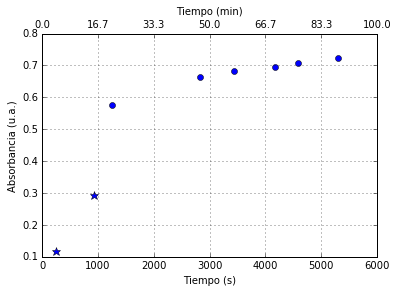

In [45]:
fig, ax1 = plt.subplots()
ax1.plot(times[:2], absorbances_waveLength[:2], "*", ms=9, color = "b")
ax1.plot(times[2:], absorbances_waveLength[2:], "o")
grid()
ax1.set_xlabel("Tiempo (s)")
ax1.set_ylabel("Absorbancia (u.a.)")
ax2 = ax1.twiny()
ax2.set_xlabel('Tiempo (min)')
ax2.set_xticks(ax1.get_xticks()/60)
savefig("Absorbance.pdf")
show()

#estimate = (max(final)-B)/A
#totalTime = time.strftime('%H:%M:%S', time.gmtime(estimate))
#print("Total time is:", totalTime)

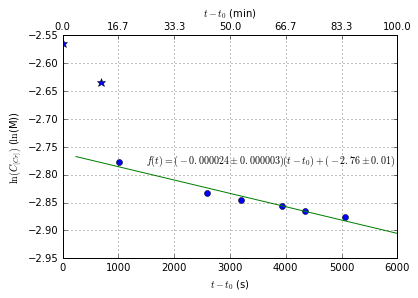

In [44]:
first_order = np.log10(chromium_concentration)

popt, pcov = curve_fit(func, times[2:]-times[0], first_order[2:])
A, B = popt
a, b = np.sqrt(np.diag(pcov))
x = np.linspace(times[0], 6000, 100)
y = func(x, A, B)

fig, ax1 = plt.subplots()
ax1.plot(times[2:]-times[0], first_order[2:], "o")
ax1.plot(x, y)
ax1.plot(times[:2]-times[0], first_order[:2], "*", ms=9, color = "b")
ax1.set_xlabel("$t-t_0$ (s)")
ax1.set_ylabel("$\ln(C_{[Cr]})$ ($\ln$(M))")
ax1.text(1500, -2.78, "$f(t)=(%.6f\pm%.6f)(t-t_0) + (%.2f\pm%.2f)$"%(A,a,B,b))
grid()
ax2 = ax1.twiny()
ax2.set_xlabel('$t-t_0$ (min)')
ax2.set_xticks(ax1.get_xticks()/60)
savefig("Logarithmic.pdf")
show()

# 3D plots

In [6]:
def appendCorners(x, y, z):
    x = x.tolist()
    y = y.tolist()
    z = z.tolist()
    x.insert(0, x[0])
    y.insert(0, y[0])
    z.insert(0, 0)
    
    x.append(x[-1])
    y.append(y[0])
    z.append(0)
    
    return x, y, z

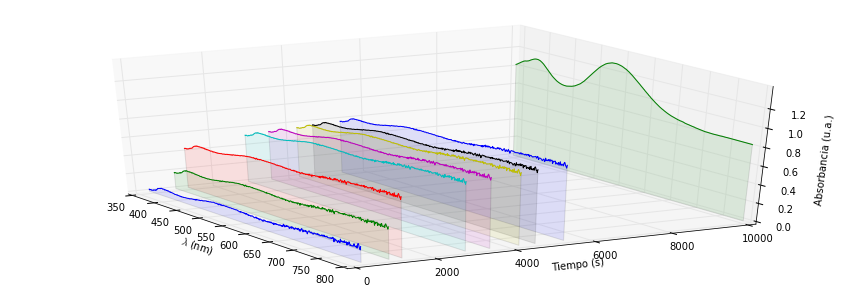

In [7]:
fig = figure(figsize=(15, 5))
ax = fig.gca(projection='3d')
verts = []
colors = []
for i in range(len(data[0])):
    x = longitud
    y = times[i] * longitud/longitud
    z = data[:,i]
    temp = ax.plot(x,y,z)
    color = temp[0].get_color()
    colors.append(color)
    
    x, y, z = appendCorners(x, y, z)
    verts.append(list(zip(x,y,z)))

x, y, z = longitud, 10000*final/final, final
temp = ax.plot(x, y, z)
color = temp[0].get_color()
colors.append(color)

x, y, z = appendCorners(x,y,z)
verts.append(list(zip(x,y,z)))

poly = Poly3DCollection(verts, facecolors=colors)
poly.set_alpha(0.1)
ax.add_collection3d(poly)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_xlim3d(350, 800)
ax.set_ylabel("Tiempo (s)")
ax.set_ylim3d(0, 10000)
ax.set_zlabel("Absorbancia (u.a.)")
ax.set_zlim3d(0, 1.4)

ax.view_init(30, -30)
show()
#fig.savefig("3dplot.png")

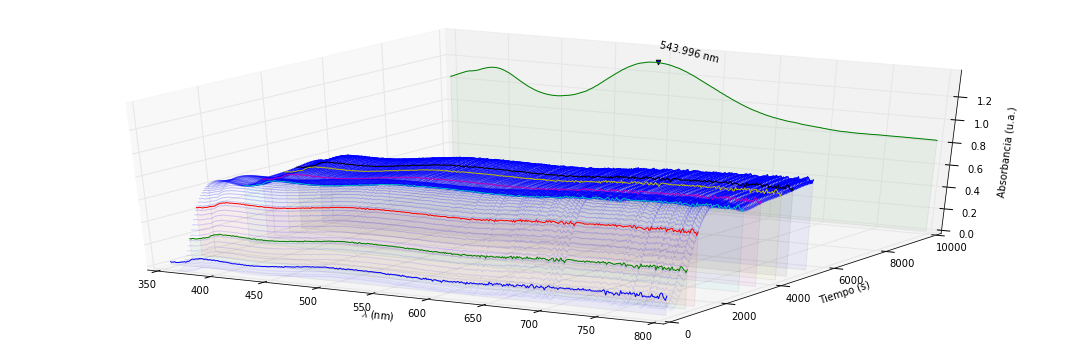

In [69]:
x_inter = np.linspace(times[0], times[-1], 100)
y = np.zeros((len(longitud), len(x_inter)))
i = 0
for (absorbances, waveLength) in zip(data, longitud):
    f = interp1d(times, absorbances, kind='cubic')
    temp = f(x_inter)
    y[i] = temp
    i += 1
    
fig = figure(figsize=(15, 5))
ax = fig.gca(projection='3d')
for i in range(len(y[0])):
    z = x_inter[i]*longitud/longitud
    ax.plot(longitud, z, y[:,i], color="b", alpha = i/len(y[0]))

verts = []
colors = []
for i in range(len(data[0])):
    x = longitud
    y = times[i] * longitud/longitud
    z = data[:,i]
    temp = ax.plot(x,y,z)
    color = temp[0].get_color()
    colors.append(color)
    
    x, y, z = appendCorners(x, y, z)
    verts.append(list(zip(x,y,z)))

x, y, z = longitud, 10000*final/final, final
temp = ax.plot(x, y, z)
color = temp[0].get_color()
colors.append(color)

x, y, z = appendCorners(x,y,z)
verts.append(list(zip(x,y,z)))

poly = Poly3DCollection(verts, facecolors=colors)
poly.set_alpha(0.05)
ax.add_collection3d(poly)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_xlim3d(350, 800)
ax.set_ylabel("Tiempo (s)")
ax.set_ylim3d(0, 10000)
ax.set_zlabel("Absorbancia (u.a.)")
ax.set_zlim3d(0, 1.4)

ax.text(longitud[pos], 10000, final[pos]*1.1, "%.3f nm"%longitud[pos], 'x')
ax.scatter(longitud[pos], 10000, final[pos], marker = "v")
#ax.view_init(30, -30)
#z = estimate*longitud/longitud
#ax.plot(longitud, z, final)
fig.savefig("3dplot.pdf")
plt.tight_layout()
show()

# Reaction rate

$$\dfrac{d[Cr]}{d[Cr]^m} = -kdt$$

$$f([Cr]) - f([Cr_0]) = -k(t-t_0)$$

In [46]:
def integrator(initial, minTry, maxTry, number):
    x = Symbol('[C]')
    equations = []
    constants = []
    bs = []
    ms = np.linspace(minTry, maxTry, number)
    for m in ms:
        temp = integrate(1/(x**m), x)
        inA0 = temp.evalf(subs={x:chromium_concentration[initial]})
        ks = []
        sols = []
        y = []
        for i in range(initial,len(times)):
            inA = temp.evalf(subs={x:chromium_concentration[i]})
            y.append(inA)
        k, B = np.polyfit(times[initial:], y, 1)
        k = -k
        constants.append(k)
        bs.append(B)
        equations.append(temp)
        print("Equation:", temp, k)
        
    x_values = np.linspace(0.0001, chromium_concentration[0], 100)#chromium_absorbances[0], 100)
    solutions = []
    i = 0
    for (symbolic_equation, k) in zip(equations, constants):
        sol = []
        temp_A0 = symbolic_equation.evalf(subs={x:chromium_concentration[initial]})
        for value in x_values:
            temp = symbolic_equation.evalf(subs={x:value})
            time = (temp_A0 - temp)/k + times[initial]
            sol.append(time)
        solutions.append(sol)
        i += 1
        
    fig, ax1 = plt.subplots(figsize=(15,5))
#    figure(figsize=(15,5))
    i = 0
    for (sol, eq) in zip(solutions, equations):
        ax1.plot(sol, x_values, label=r"$"+latex(eq)+r"$")
        i += 1
    ax1.plot(times[:2], chromium_concentration[:2], "*", ms=9,color="b")    
    ax1.plot(times[2:], chromium_concentration[2:], "o", color="b")
    ylim(0, 0.003)
    xlabel("Tiempo (s)")
    ylabel("$C_{[Cr]}$ (M)")
    xlim(0, 60000)
    legend()
    grid()
    
    ax2 = ax1.twiny()
    ax2.set_xlabel('Tiempo (min)')
    ax2.set_xticks(ax1.get_xticks()/60)
    savefig("integrationLaws.pdf")
    
    errors = []
    for (symbolic_equation, k) in zip(equations, constants):
        temp_A0 = symbolic_equation.evalf(subs={x:chromium_concentration[initial]})
        error = 0
        for (value, realTime) in zip(chromium_concentration[initial:],times[initial:]):
            temp = symbolic_equation.evalf(subs={x:value})
            time = (temp_A0 - temp)/k + times[initial]
            error += abs(time-realTime)/realTime
        errors.append(error)
        print(errors)

Equation: 0.333333333333333*[C]**3.0 1.09119909731e-13
Equation: 0.4*[C]**2.5 2.91516245067e-12
Equation: 0.5*[C]**2.0 7.78929549735e-11
Equation: 0.666666666666667*[C]**1.5 2.08166237774e-09
Equation: [C] 5.56415383347e-08
Equation: 2.0*[C]**0.5 1.48752645796e-06
Equation: log([C]) 3.9774708444e-05
Equation: -2.0*[C]**(-0.5) 0.00106371683492
Equation: -1.0*[C]**(-1.0) 0.0284525867294
[0.115472972716386]
[0.115472972716386, 0.105166122580415]
[0.115472972716386, 0.105166122580415, 0.0948938053951757]
[0.115472972716386, 0.105166122580415, 0.0948938053951757, 0.0846579778174622]
[0.115472972716386, 0.105166122580415, 0.0948938053951757, 0.0846579778174622, 0.0774681503496507]
[0.115472972716386, 0.105166122580415, 0.0948938053951757, 0.0846579778174622, 0.0774681503496507, 0.0748174536255864]
[0.115472972716386, 0.105166122580415, 0.0948938053951757, 0.0846579778174622, 0.0774681503496507, 0.0748174536255864, 0.0721970481579084]
[0.115472972716386, 0.105166122580415, 0.0948938053951757,

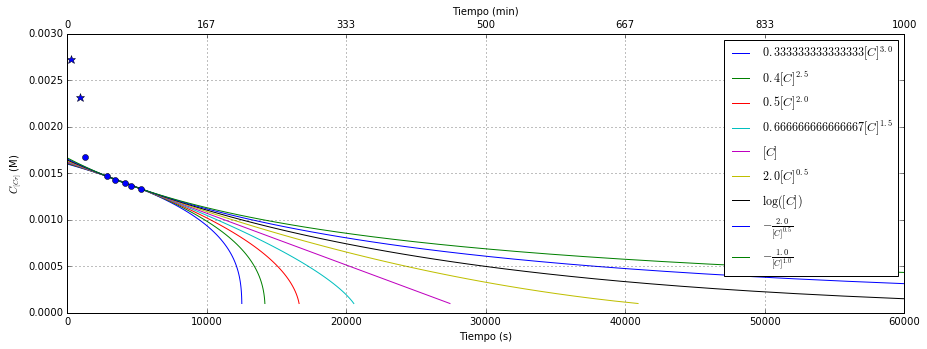

In [50]:
integrator(3, -2, 2, 9)

# Group data analysis

In [2]:
pH_data = np.genfromtxt("pH.csv", delimiter=",")

In [22]:
maxAbsorbance = [1.547, 1.3, 1.237, 1.169, 1.476, 1.254, 1.262, 1.262]
def importData(pH_data):
    data_pairs = int(len(pH_data[0])/2)
    points = len(pH_data[:]) - 2
    pH = [pH_data[0, i*2] for i in range(data_pairs)]
    tiempos = []
    absorbances = []
    for i in range(data_pairs):
        tiempo = pH_data[:, i*2][2:]
        absorbance = pH_data[:, 2*i+1][2:]
        no_ceros = 0
        for item in tiempo:
            if item == 0 and no_ceros != 0:
                break
            no_ceros += 1
        tiempo = tiempo[:no_ceros]#*60
        absorbance = absorbance[:no_ceros]
        tiempos.append(tiempo)
        absorbances.append(absorbance)
    return pH, tiempos, absorbances

pH, tiempos, absorbances = importData(pH_data)

[array([ 10.,  20.,  30.,  40.,  50.,  60.]), array([  4.  ,  15.4 ,  20.73,  46.98,  57.22,  69.47,  76.33,  88.45]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]), array([  0.,  15.,  26.,  35.,  45.,  55.,  65.]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  75.,  80.]), array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.])]


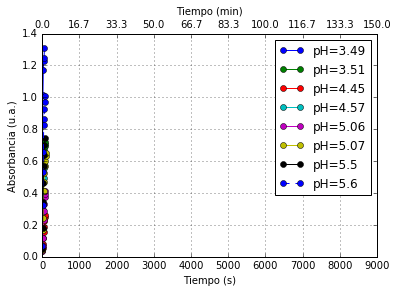

In [15]:
fig, ax1 = plt.subplots()
for (pH_value, tiempo, absorbance) in zip(pH, tiempos, absorbances):
    style = "-o"
    if pH_value == pH[-1]:
        style = "--o"
    ax1.plot(tiempo, absorbance, style, label="pH="+str(pH_value))
ax1.set_xlim(0, 9000)
ax1.set_xlabel("Tiempo (s)")
ax1.set_ylabel("Absorbancia (u.a.)")
grid()
ax2 = ax1.twiny()
ax2.set_xlabel('Tiempo (min)')
ax2.set_xticks(ax1.get_xticks()/60)
ax1.legend()
#savefig("Absorbance.pdf")
show()

In [23]:
concentration = 3*10**(-3)
b = 1
chromium_concentration = []
for (absorbance, maxValue) in zip(absorbances, maxAbsorbance):
    epsilon = maxValue/(concentration*b)
    print(epsilon)
    chromium_absorbances = [maxValue-absor for absor in absorbance]
    temp = [absor/(epsilon*b) for absor in chromium_absorbances]
    chromium_concentration.append(temp)

515.6666666666666
433.3333333333333
412.33333333333337
389.6666666666667
492.0
418.0
420.6666666666667
420.6666666666667


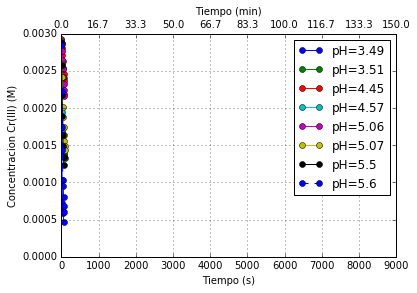

In [24]:
fig, ax1 = plt.subplots()

i = 0
for (pH_value, tiempo, absorbance) in zip(pH, tiempos, chromium_concentration):
    if i == 0:
        popt, pcov = curve_fit(func, tiempo[2:]-tiempo[0], absorbance[2:])
    else:
        popt, pcov = curve_fit(func, tiempo-tiempo[0], absorbance)
    style = "-o"
    if pH_value == pH[-1]:
        style = "--o"
    ax1.plot(tiempo, absorbance, style, label="pH="+str(pH_value))
    i += 1
ax1.set_xlim(0, 9000)
ax1.set_xlabel("Tiempo (s)")
ax1.set_ylabel("Concentracion Cr(III) (M)")
grid()
ax2 = ax1.twiny()
ax2.set_xlabel('Tiempo (min)')
ax2.set_xticks(ax1.get_xticks()/60)
ax1.legend()
#savefig("primerOrden.pdf")
show()

In [29]:
log_concentration = [np.log(concentration) for concentration in chromium_concentration]

$\ln([Cr])=(-0.024 \pm 0.0037)t + (-6.58 \pm 0.11)$ 3.49
$\ln([Cr])=(-0.0033 \pm 0.00035)t + (-6.36 \pm 0.02)$ 3.51
$\ln([Cr])=(-0.0028 \pm 9.2e-05)t + (-5.83 \pm 0.00)$ 4.45
$\ln([Cr])=(-0.011 \pm 0.00073)t + (-5.92 \pm 0.03)$ 4.57
$\ln([Cr])=(-0.004 \pm 7.7e-05)t + (-5.82 \pm 0.00)$ 5.06
$\ln([Cr])=(-0.0071 \pm 0.00031)t + (-5.89 \pm 0.02)$ 5.07
$\ln([Cr])=(-0.013 \pm 0.0005)t + (-5.87 \pm 0.02)$ 5.5
$\ln([Cr])=(-0.02 \pm 0.00096)t + (-5.94 \pm 0.05)$ 5.6


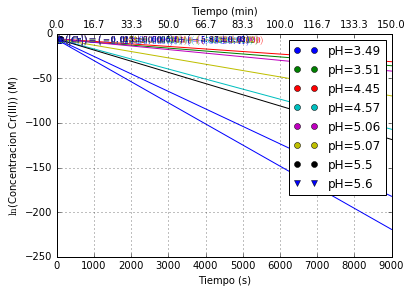

In [30]:
fig, ax1 = plt.subplots()

bigKs = []
def func(x, a, b):
    return a*x + b

i = 0
for (pH_value, tiempo, absorbance) in zip(pH, tiempos, log_concentration):
    if i == 1:
        popt, pcov = curve_fit(func, tiempo[2:]-tiempo[0], absorbance[2:])
    else:
        popt, pcov = curve_fit(func, tiempo-tiempo[0], absorbance)
    A, B = popt
    a, b = np.sqrt(np.diag(pcov))
    x = np.linspace(0, 9000, 100)
    y = func(x, A, B)
    line = ax1.plot(x, y)[0]
    style = "o"
    if pH_value == pH[-1]:
        style = "v"
    text = "pH="+str(pH_value)
    ax1.plot(tiempo, absorbance, style, color=line.get_color(), label=text)
    bigKs.append(-A)
    text = "$\ln([Cr])=(%.2g \pm %.2g)t + (%.2f \pm %.2f)$"%(A, a, B, b)
    print(text, pH_value)
    ax1.text(0, -10.9 + i/3, text, color=line.get_color(), fontsize=9)    
    i += 1
    
ax1.set_xlabel("Tiempo (s)")
ax1.set_ylabel("$\ln$(Concentracion Cr(III)) (M)")
grid()
ax2 = ax1.twiny()
ax2.set_xlabel('Tiempo (min)')
ax2.set_xticks(ax1.get_xticks()/60)
ax1.legend()#loc='upper left', bbox_to_anchor=(1.02, 1))
#fig.savefig("Logarithmic.pdf")
show()

In [97]:
log_10_bigKs = [np.log10(k) for k in bigKs]
temp_y = []
temp_x = []
for i in range(len(log_10_bigKs)):
    if i >= 1:
        temp_x.append(pH[i])
        temp_y.append(log_10_bigKs[i])

m= -0.317541843286 0.141351214683 k= 3.37722153362e-06 2.68480008386e-06


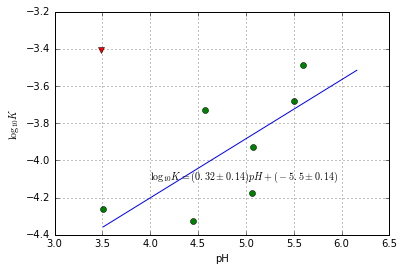

In [104]:
popt, pcov = curve_fit(func, temp_x, temp_y)
A, B = popt
a, b = np.sqrt(np.diag(pcov))
print("m=", -A, a,"k=", 10**B, 10**B-10**(B-b))
x = np.linspace(temp_x[0], temp_x[-1]*1.1, 10)
y = A*x + B
plt.plot(x, y)
plt.plot(temp_x, temp_y, "o")
plt.plot(pH[0], log_10_bigKs[0], "v")
plt.xlabel("pH")
plt.ylabel("$\log_{10}K$")
plt.text(4.0, -4.1, "$\log_{10}K=(%.2g\pm%.2g)pH + (%.2g\pm%.2g)$"%(A, a, B, a))
plt.ylim(-4.4, -3.2)
plt.grid()
plt.savefig("pH.pdf")